# Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import urllib.request

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

import time

from sklearn.linear_model import LinearRegression

# Functions to format strings

In [2]:
def format_baths(baths_str):

    if '-' in baths_str:
        left, right = baths_str.split(' - ')
        return format_baths(left) + ' - ' + format_baths(right)

    return re.findall(r'\d+', baths_str)[0]

In [3]:
def format_beds(beds_str):

    if '-' in beds_str:
        left, right = beds_str.split(' - ')
        return format_beds(left) + ' - ' + format_beds(right)

    if beds_str == 'Studio':
        return '0'

    return re.findall(r'\d+', beds_str)[0]

# Main work horse
This function loops over each property in the `properties` list and gets data from it. It formats the data into a semi-workable format. It temporarily saves this data in a dictionary before converting to a Pandas DataFrame.

In [4]:
def get_property_df(properties):

    property_data = {
        'buy_type': [],
        'desc': [],
        'address': [],
        'price': [],
        'beds': [],
        'baths': [],
        'sqft': [],
        'pets': []
    }

    for property in properties:

        try:
            prop_description = property.find_all('div', attrs={'data-testid': 'card-description'})[0].text
            
            rent_or_sale = prop_description.split(' ')[1].lower()
            house_or_apartment = prop_description.split(' ')[3].lower()

            price = property.find_all('div', attrs={'data-testid': 'card-price'})[0].text

            address_line_1 = property.find_all('div', attrs={'data-testid': 'card-address-1'})[0].text
            address_line_2 = property.find_all('div', attrs={'data-testid': 'card-address-2'})[0].text
            address = address_line_1 + ', ' + address_line_2

            beds = property.find_all('li', attrs={'data-testid': 'property-meta-beds'})
            if len(beds) == 0:
                beds = 'nan'
            else:
                beds = format_beds(beds[0].text)
            
            baths = property.find_all('li', attrs={'data-testid': 'property-meta-baths'})
            if len(baths) == 0:
                baths = 'nan'
            else:
                baths = format_baths(baths[0].text)

            sqft = property.find_all('li', attrs={'data-testid': 'property-meta-sqft'})
            if len(sqft) == 0:
                sqft = 'nan'
            else:
                sqft = sqft[0].text
                sqft = sqft.split('sqft')[0]

            pets = property.find_all('li', attrs={'data-testid': 'property-meta-pet'})
            if len(pets) == 0:
                pets = 'nan'
            else:
                pets = pets[0].text
                pets = pets.split('OK')[0]
                pets = pets.lower()
                if pets == 'pets':
                    pets = 'all pets'

            # try:
            #     image_source = property.find_all('div', attrs={'class': 'Picture_photo-wrap__CDzzG'})[0].find_all('img')[0]['srcset']
            #     if ',' in image_source:
            #         image_source = image_source.split(',')[0]
            #     print(image_source)
            #     # image = requests.get(image_source)
            #     # if image.status_code == 200:
            #     #     urllib.request.urlretrieve(image_source, f"images/{address.replace(' ', '+')}.jpg")
            # except:
            #     continue

            property_data['buy_type'].append(rent_or_sale)
            property_data['desc'].append(house_or_apartment)
            property_data['address'].append(address)
            property_data['price'].append(price)
            property_data['beds'].append(beds)
            property_data['baths'].append(baths)
            property_data['sqft'].append(sqft)
            property_data['pets'].append(pets)

        except IndexError:
            continue

    return pd.DataFrame(property_data)

# Formats minimum and maximum values

In [5]:
def format_min_and_max(value):
    value = value.replace('$', '')
    value = value.replace(',', '')

    if ' - ' in value:
        return value.split(' - ')
    
    return value, value

# Main loop
Loops over pages 1-5 of the Realator.com apartments search page for Greenville, SC. Aggregates Pandas DataFrames from the function `get_property_df`. End result is one DataFrame, `df`, that contains all the data.

In [9]:
min_price = 1000
max_price = 1600

headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"}

df = None

for page_number in range(1, 6):
    url = f"https://www.realtor.com/apartments/Greenville_SC/pg-{page_number}"

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    properties = soup.find_all('div', attrs={'class': "BasePropertyCard_propertyCardWrap__pblQC"})

    property_df = get_property_df(properties)
    if df is None:
        df = property_df
    else:
        df = pd.concat((df, property_df))

    print(page_number)




Pardon Our Interruption













This page requires JavaScript!




Pardon Our Interruption...





        As you were browsing, something about your browser made us think you might be a bot. There are a few reasons this might happen, including:
      

You're a power user moving through this website with super-human speed
You've disabled JavaScript and/or cookies in your web browser
A third-party browser plugin is preventing JavaScript from running.


          Reference ID: #8dd0d107-941d-11ed-b934-55784c586362
      

 Please complete the Challenge below, to regain access to the site.








      Please contact Customer Service at (800) 878-4166  or unblockrequest@realtor.com with any issues. Please include the Reference ID shown above.
    







1



Pardon Our Interruption













This page requires JavaScript!




Pardon Our Interruption...





        As you were browsing, something about your browser made us think you might be a bot. There are a few reasons t

# Formats data to final form

In [7]:
min_and_max_columns = ['price', 'beds', 'baths', 'sqft']

for col in min_and_max_columns:
    df[[f'min_{col}', f'max_{col}']] = df.apply(lambda x: format_min_and_max(x[col]), axis=1, result_type='expand')

df.drop(columns=min_and_max_columns, inplace=True)
df.reset_index(inplace=True, drop=True)

df[['min_price', 'max_price', 'min_beds', 'max_beds', 'min_baths', 'max_baths', 'min_sqft', 'max_sqft']] = df[['min_price', 'max_price', 'min_beds', 'max_beds', 'min_baths', 'max_baths', 'min_sqft', 'max_sqft']].astype('float')

ValueError: Columns must be same length as key

In [8]:
df

,buy_type,desc,address,price,beds,baths,sqft,pets


# Plots and Analyses

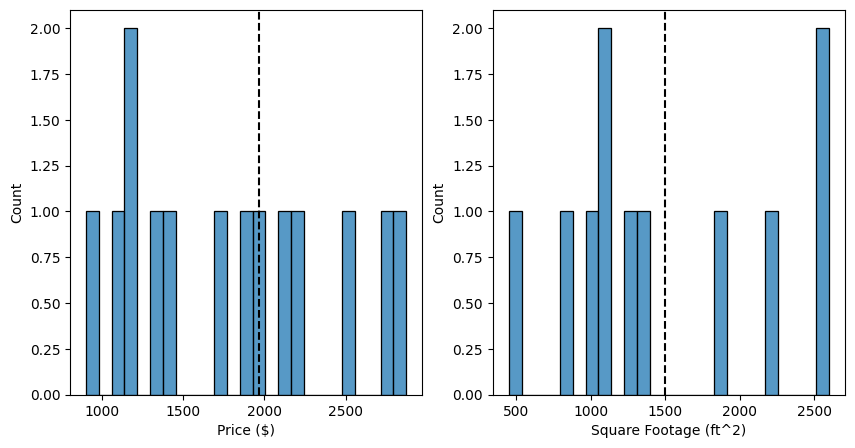

In [164]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.histplot(x='min_price', data=df[df['min_price'] < 4000], bins=25, ax=axs[0])
axs[0].axvline(df['min_price'].mean(), linestyle='--', color='k')
axs[0].set_xlabel('Price ($)')

sns.histplot(x='min_sqft', data=df, bins=25, ax=axs[1])
axs[1].axvline(df['min_sqft'].mean(), linestyle='--', color='k')
axs[1].set_xlabel('Square Footage (ft^2)')
plt.show()

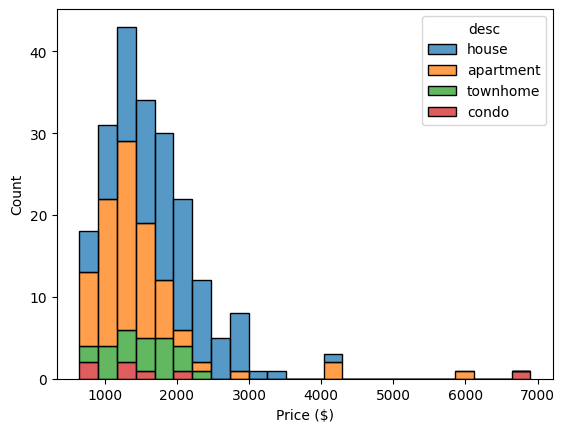

In [154]:
sns.histplot(x='min_price', data=df, hue='desc', multiple='stack')

plt.xlabel('Price ($)')
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


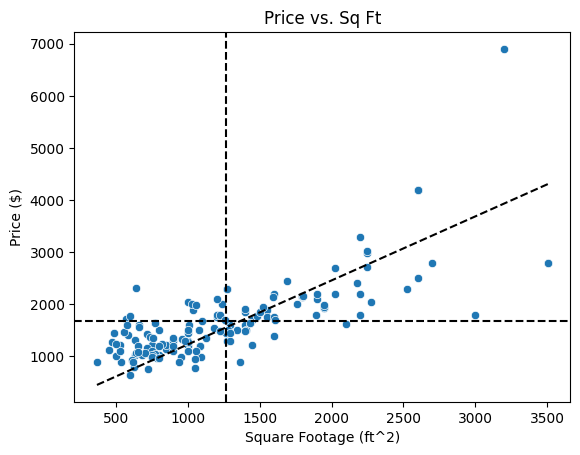

In [155]:
sns.scatterplot(x='min_sqft', y='min_price', data=df)

plt.axvline(df['min_sqft'].mean(), linestyle='--', color='k')
plt.axhline(df['min_price'].mean(), linestyle='--', color='k')

lm = LinearRegression(fit_intercept=False)
no_na = df.dropna()
X = no_na[['min_sqft']]
y = no_na[['min_price']]
lm.fit(X, y)

xs = np.linspace(df.min_sqft.min(), df.min_sqft.max()).reshape(-1, 1)
plt.plot(xs, lm.predict(xs), linestyle='--', color='k')

plt.xlabel('Square Footage (ft^2)')
plt.ylabel('Price ($)')
plt.title('Price vs. Sq Ft')
plt.show()

## Over Performers -- Big and Cheap

In [171]:
over_performers = df[(df.min_sqft > df.min_sqft.mean()) & (df.min_price < df.min_price.mean())].sort_values(by='min_price')
over_performers

,buy_type,desc,address,pets,min_price,max_price,min_beds,max_beds,min_baths,max_baths,min_sqft,max_sqft
86,rent,house,"204 Honour St, Greenville, SC 29611",nan,900.0,900.0,3.0,3.0,2.0,2.0,1360.0,1360.0
80,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0
122,rent,apartment,"110 Prospect St Unit 1, Greenville, SC 29611",all pets,1225.0,1225.0,3.0,3.0,1.0,1.0,1450.0,1450.0
121,rent,apartment,"36 Miracle Dr Unit 1, Greenville, SC 29605",nan,1450.0,1450.0,3.0,3.0,2.0,2.0,1266.0,1266.0
164,rent,townhome,"520 Hampton Townes Dr, Greenville, SC 29617",all pets,1500.0,1500.0,3.0,3.0,2.0,2.0,1280.0,1280.0
114,rent,house,"101 Sharon Dr Unit Greenville, Greenville, SC ...",all pets,1650.0,1650.0,4.0,4.0,2.0,2.0,1430.0,1430.0


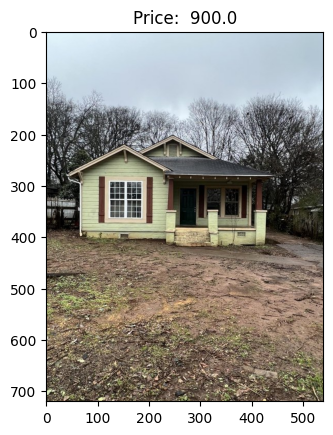

UnidentifiedImageError: cannot identify image file 'images/110+Prospect+St+Unit+1,+Greenville,+SC+29611.jpg'

In [172]:
for idx, over_performer in over_performers.iterrows():

    address = over_performer['address'].replace(' ', '+')
    price = over_performer['min_price']
    img = mpimg.imread(f"images/{address}.jpg")
    imgplot = plt.imshow(img)
    plt.title(f"Price:  {price}")
    plt.show()